In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv

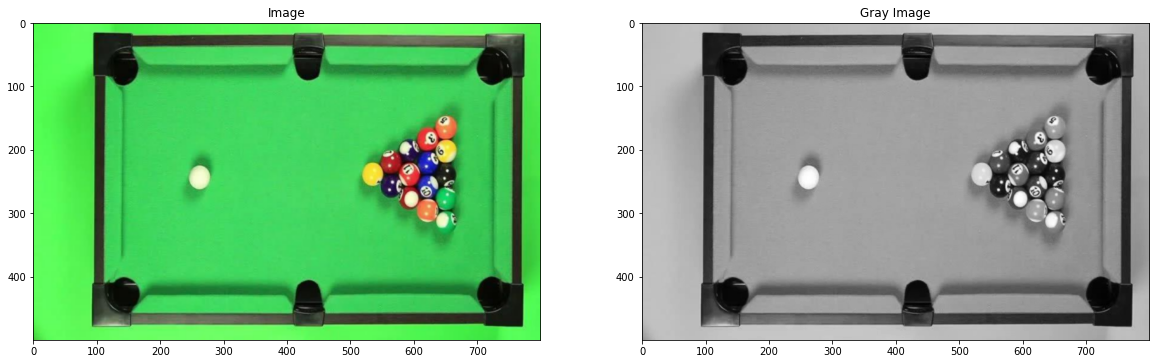

In [ ]:
#charge image
image = cv.imread("/content/Screenshot from 2022-03-26 12-51-22.png", cv.IMREAD_UNCHANGED)
image = cv.resize(image, (800,500))
image_gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
image = cv.cvtColor(image,cv.COLOR_BGR2RGB)

# show images

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('Image')
ax1.imshow(image, cmap='gray')

ax2.set_title('Gray Image')
ax2.imshow(image_gray, cmap='gray')

plt.show()

In [ ]:
#remove green background
im = cv.cvtColor(image, cv.COLOR_RGB2HSV)
h_hist = cv.calcHist([im], [0], None, [180], [0, 180])
s_hist = cv.calcHist([im], [1], None, [255], [0, 255])
v_hist = cv.calcHist([im], [2], None, [255], [0, 255])
h_g = np.where(h_hist==np.max(h_hist))
s_g = np.where(s_hist==np.max(s_hist))
v_g = np.where(v_hist==np.max(v_hist))

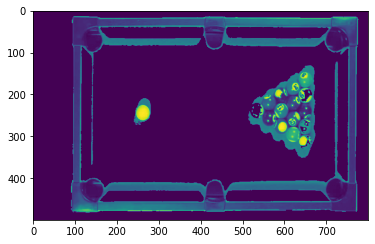

In [ ]:
sum = 40
lower_g = np.array([h_g[0][0]-sum,s_g[0][0]-sum,v_g[0][0]-sum])
upper_g = np.array([h_g[0][0]+sum,s_g[0][0]+sum,v_g[0][0]+sum])
green_out = cv.inRange(im, lower_g, upper_g)
image_gray[green_out != 0] = [0]

plt.imshow(image_gray)

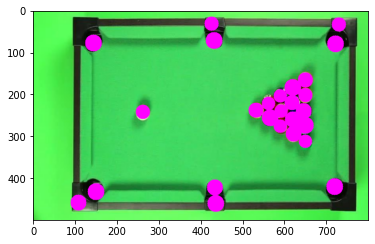

In [ ]:
minR = 15
maxR = int(np.round(minR*1.4)) #Estos valores serán definidos automáticamente en un versión posterior

image_cp = np.copy(image)

#Hough circles
circ = cv.HoughCircles(image_gray,
                       cv.HOUGH_GRADIENT,
                       1,
                       minDist = 30,
                       param1 = 100,
                       param2 = 10,
                       minRadius = minR,
                       maxRadius = maxR)


if circ is not None:
  circ = np.uint16(np.around(circ))
  for c in circ[0,:]:
      cv.circle(image_cp, (c[0],c[1]), c[2], (255,0,255),-1)


# plot results
plt.imshow(image_cp)
plt.show()

In [ ]:
def mask(img,lower,upper):
  return cv.inRange(img,np.array(lower),np.array(upper))

# Identificación de los colores
image_c = np.copy(image)

#RGB
colors_of_balls = np.array([[[129,162,0],[255,255,109]],
                            [[0,0,115],[78,100,255]],
                            [[10,0,41],[63,37,94]],
                            [[0,64,0],[26,255,255]],
                            [[202,104,0],[255,164,88]],
                            [[194,24,0],[255,96,76]],
                            [[96,0,0],[198,84,255]]])

yellow_balls = mask(image_c,[129,162,0], [255,255,109])
blue_balls = mask(image_c,[0,0,115],[78,100,255])
violet_balls = mask(image_c,[10,0,41],[63,37,94])
green_balls = mask(image_c,[0,64,0],[26,255,255])
orange_balls = mask(image_c,[202,104,0],[255,164,88])
red_balls = mask(image_c,[194,24,0],[255,96,76])
fux_balls = mask(image_c,[96,0,0],[198,84,255])

list_balls = np.array([yellow_balls,
                      blue_balls,
                      violet_balls,
                      green_balls,
                      orange_balls,
                      red_balls,
                      fux_balls])


In [ ]:
colors_of_balls[5]

array([[194,  24,   0],
       [255,  96,  76]])

In [ ]:
#variables

holes = []
coordinates = circ[0,:]
final_coord = []
cropped = []

masks = []
cropped_holes = []
cropped_holes_rgb = []
cropped_balls_color = []

h = image.shape[0]
w = image.shape[1]
#

for idc, coord in enumerate(coordinates):
  zeros = np.uint8(np.zeros((h,w)))

  bitw = cv.circle(zeros,
                   (coord[0],coord[1]),
                   coord[2],
                   255,
                   -1)
  holes.append(bitw)

cont = 0
for idx, h in enumerate(holes): #hole
  for idy, cb in enumerate(list_balls): #color ball
    m = cv.bitwise_and(cb, h)
    x = coordinates[idx][0]
    y = coordinates[idx][1]
    r = 25
    cropped = m[y-r:y+r, x-r:x+r]
    th, im_bin = cv.threshold(cropped, 250, 255, cv.THRESH_BINARY)

    if np.mean(im_bin) > 10:
      masks.append(m)
      cropped_holes.append(cropped)
      cropped_holes_rgb.append(image[y-r:y+r, x-r:x+r])
      final_coord.append(coordinates[idx])
      print(idx, coordinates[idx], np.mean(cropped))

      #cropped_holes_rgb[cont][cropped_holes[cont] != 0] = [0,0,0]
      cropped_balls_color.append(cv.bitwise_and(cropped_holes_rgb[cont], cropped_holes_rgb[cont], mask=cropped_holes[cont]))
      cont+=1
      break

1 [592 240  16] 33.456
2 [566 256  20] 54.162
3 [532 238  18] 87.108
4 [650 202  17] 51.0
5 [562 222  16] 64.872
7 [622 294  19] 58.344
8 [618 220  18] 57.324
9 [650 274  20] 50.592
10 [590 276  16] 23.97
11 [620 184  20] 48.654
14 [620 260  19] 28.764
16 [650 166  18] 45.9
18 [650 312  16] 10.914
19 [590 204  16] 27.234


[592 240  16]
[566 256  20]
[532 238  18]
[650 202  17]
[562 222  16]
[622 294  19]
[618 220  18]
[650 274  20]
[590 276  16]
[620 184  20]
[620 260  19]
[650 166  18]
[650 312  16]
[590 204  16]


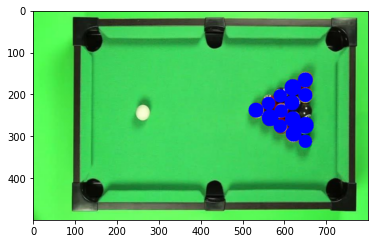

In [ ]:
#show coordinates into original image

image_b = np.copy(image)
for c in final_coord:
  print(c)
  cv.circle(image_b, (c[0],c[1]), c[2], (0,0,255),-1)
# plot results
plt.imshow(image_b)
plt.show()

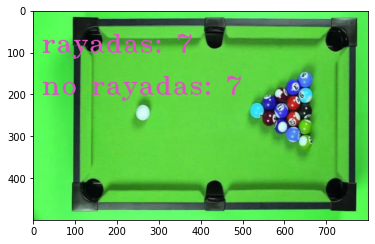

In [ ]:
'''
def commomly_Hist_rgb(imge):
  r_hist = cv.calcHist([imge], [0], None, [255], [0, 255])
  g_hist = cv.calcHist([imge], [1], None, [255], [0, 255])
  b_hist = cv.calcHist([imge], [2], None, [255], [0, 255])
  r_g = np.where(r_hist==np.max(r_hist))
  g_g = np.where(g_hist==np.max(g_hist))
  b_g = np.where(b_hist==np.max(b_hist))
  return  r_g[]] g_g, b_g


for idx,i in enumerate(cropped_balls_color):
  for idy, j in enumerate(colors_of_balls): #lista de colores
     r1 = j[0][0]
     g1 = j[0][1]
     b1 = j[0][2]
     r2 = j[1][0]
     g2 = j[1][1]
     b2 = j[1][2]

     r,g,b = commomly_Hist_rgb(cv.split(cropped_balls_color[idx]))
     print(r,g,b)
     if(r > r1 and r <= r2 and g > g1 and g <= g2 and b > b1 and b <= b2):
       print(f"{idx} pertenece a {idy}")
       print("sdfasd")
'''
rayada = 0
no_rayada = 0
for idx, i in enumerate(cropped_balls_color):
  if np.mean(cv.cvtColor(cropped_balls_color[idx], cv.COLOR_RGB2GRAY)>125):
    rayada+=1
  else:
    no_rayada+=1


final1 = np.copy(image)
final = cv.cvtColor(final1, cv.COLOR_BGR2RGB)
cv.putText(final, f"rayadas: {rayada}", (20, 100), cv.FONT_HERSHEY_TRIPLEX, 2, (221,82,196), 2)
cv.putText(final, f"no rayadas: {no_rayada}", (20, 200), cv.FONT_HERSHEY_TRIPLEX, 2, (221,82,196), 2)
plt.imshow(final)
